# 1. Assignment 1

**Group**

* Elske Nijhof (`2071325`)
* Sem Uijen (`2065789`)
* Tom de Wildt (`2068292`)

**Import packages**

In [1]:
from collections import Counter
from datetime import datetime
from functools import reduce
from pprint import pprint
import pickle
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import words
from bs4 import BeautifulSoup
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

In [2]:
# Progress bar for apply function in pandas
tqdm.pandas()

**Settings**

In [3]:
# Folders
RAW_DATASET_FOLDER = "../data/"
INTERIM_DATASET_FOLDER = "../data/"
PROCESSED_DATASET_FOLDER = "../data/"
MODEL_CHECKPOINTS_FOLDER = "../checkpoints/"

# Raw datasets
STOCK_DATASET_FILE = "aapl.csv"
NEWS_DATASET_FILE = "us_equities_news.csv"

# Interim datasets
PREP_DATA_JOIN_DATASET_FILE = "aapl_us_equities_news_prep_data_join.csv"
PREP_DATA_JOIN_SUBSET_DATASET_FILE = "aapl_us_equities_news_prep_data_join_subset.csv"
PREP_DATA_JOIN_SUBSET_CLEAN_DATASET_FILE = "aapl_us_equities_news_prep_data_join_subset_clean.csv"
PREP_DATA_JOIN_SUBSET_CLEAN_TARGET_DATASET_FILE = "aapl_us_equities_news_prep_data_join_subset_clean_target.csv"

PREP_TEXT_CONSOL_DATASET_FILE = "aapl_us_equities_news_prep_text_consol.csv"
PREP_TEXT_CONSOL_HTML_DATASET_FILE = "aapl_us_equities_news_prep_text_consol_html.csv"
PREP_TEXT_CONSOL_HTML_EOL_DATASET_FILE = "aapl_us_equities_news_prep_text_consol_html_eol.csv"
PREP_TEXT_CONSOL_HTML_EOL_OTHER_DATASET_FILE = "aapl_us_equities_news_prep_text_consol_html_eol_other.csv"
PREP_TEXT_CONSOL_HTML_EOL_OTHER_SPACE_DATASET_FILE = "aapl_us_equities_news_prep_text_consol_html_eol_other_space.csv"
PREP_TEXT_CONSOL_HTML_EOL_OTHER_SPACE_LOWER_DATASET_FILE = "aapl_us_equities_news_prep_text_consol_html_eol_other_space_lower.csv"
PREP_TEXT_CONSOL_HTML_EOL_OTHER_SPACE_LOWER_DICT_SINGLE_STOP_LEMMA_DATASET_FILE = "aapl_us_equities_news_prep_text_consol_html_eol_other_space_lower_dict_single_stop_lemma.csv"

# Processed datasets
PROC_DATA_DATASET_FILE = "aapl_us_equities_news_proc_data.csv"
PROC_TEXT_DATASET_FILE = "aapl_us_equities_news_proc_text.csv"

# Settings
SAVE_INTERIM_DATASETS = False
SAVE_PROCESSED_DATASETS = False
SAVE_MODEL_CHECKPOINTS = True

RANDOM_SEED = 42

# Other
TEXT_START = "\033[1m"
TEXT_END = "\033[0m"

In [4]:
np.random.seed(RANDOM_SEED)

## 1.1 Import data

In [5]:
%%time
df_aapl = pd.read_csv(RAW_DATASET_FOLDER + STOCK_DATASET_FILE)
df_us_equities_news = pd.read_csv(RAW_DATASET_FOLDER + NEWS_DATASET_FILE)

CPU times: user 4.97 s, sys: 321 ms, total: 5.29 s
Wall time: 5.29 s


## 1.2 Preprocess data

### 1.2.1 Prepare data

**Rename columns**

In [6]:
df_aapl = df_aapl.rename(columns={
    "Date": "date",
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Adj Close": "adj_close",
    "Volume": "volume",
})

**Set data types**

In [7]:
df_aapl["date"] = pd.to_datetime(df_aapl["date"])
df_aapl["open"] = df_aapl["open"].astype("float")
df_aapl["high"] = df_aapl["high"].astype("float")
df_aapl["low"] = df_aapl["low"].astype("float")
df_aapl["close"] = df_aapl["close"].astype("float")
df_aapl["adj_close"] = df_aapl["adj_close"].astype("float")
df_aapl["volume"] = df_aapl["volume"].astype(int)

**Rename columns**

In [8]:
df_us_equities_news = df_us_equities_news.rename(columns={"release_date": "date"})

**Set data types**

In [9]:
df_us_equities_news["id"] = df_us_equities_news["id"].astype(int)
df_us_equities_news["ticker"] = df_us_equities_news["ticker"].astype("category")
df_us_equities_news["title"] = df_us_equities_news["title"].astype(str)
df_us_equities_news["category"] = df_us_equities_news["category"].astype("category")
df_us_equities_news["content"] = df_us_equities_news["content"].astype(str)
df_us_equities_news["date"] = pd.to_datetime(df_us_equities_news["date"])
df_us_equities_news["provider"] = df_us_equities_news["provider"].astype("category")
df_us_equities_news["url"] = df_us_equities_news["url"].astype(str)
df_us_equities_news["article_id"] = df_us_equities_news["article_id"].astype(int)

### 1.2.2 Join data

In [10]:
df_aapl_us_equities_news = pd.merge(df_us_equities_news, df_aapl, on="date", how="inner").sort_values("date")

**(Optionally) Save data**

In [11]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_DATA_JOIN_DATASET_FILE, index=False)

### 1.2.3 Subset data

In [12]:
df_aapl_us_equities_news = df_aapl_us_equities_news[df_aapl_us_equities_news["ticker"] == "AAPL"]

**(Optionally) Save data**

In [13]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_DATA_JOIN_SUBSET_DATASET_FILE, index=False)

### 1.2.4 Clean data

**Remove duplicate rows**

In [14]:
print(f"Rows (Before): {df_aapl_us_equities_news.shape[0]}")
df_aapl_us_equities_news = df_aapl_us_equities_news.drop_duplicates(subset=["title", "content"])
print(f"Rows (After): {df_aapl_us_equities_news.shape[0]}")

Rows (Before): 17648
Rows (After): 17634


**Remove null values**

In [15]:
print(f"Rows (Before): {df_aapl_us_equities_news.shape[0]}")
df_aapl_us_equities_news = df_aapl_us_equities_news[
    (df_aapl_us_equities_news["title"] != "nan")
    & (df_aapl_us_equities_news["content"] != "nan")
]
print(f"Rows (After): {df_aapl_us_equities_news.shape[0]}")

Rows (Before): 17634
Rows (After): 17634


**Remove unused columns**

In [16]:
df_aapl_us_equities_news = df_aapl_us_equities_news.drop(columns=["article_id"])

**Reset index**

In [17]:
df_aapl_us_equities_news = df_aapl_us_equities_news.reset_index(drop=True)

**Sort rows**

In [18]:
df_aapl_us_equities_news = df_aapl_us_equities_news.sort_values("date")

**(Optionally) Save data**

In [19]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_DATA_JOIN_SUBSET_CLEAN_DATASET_FILE, index=False)

### 1.2.5 Add target to data

In [20]:
df_aapl_us_equities_news["target"] = (df_aapl_us_equities_news["close"] > df_aapl_us_equities_news["open"]).astype(int)

**(Optionally) Save data**

In [21]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_DATA_JOIN_SUBSET_CLEAN_TARGET_DATASET_FILE, index=False)

if SAVE_PROCESSED_DATASETS:
    df_aapl_us_equities_news.to_csv(PROCESSED_DATASET_FOLDER + PROC_DATA_DATASET_FILE, index=False)

## 1.3 Explore data

### 1.3.1 Inspect rows

In [22]:
df_aapl_us_equities_news.head(10)

,id,ticker,title,category,content,date,provider,url,open,high,low,close,adj_close,volume,target
0,290924,AAPL,Waiting For Direction On The Markets,opinion,This stock market has been a difficult one for...,2012-07-16,Cam Hui,https://www.investing.com/analysis/waiting-for...,21.611429,21.843571,21.607857,21.675358,18.507113,301260400,1
1,290925,AAPL,Mid Year Update U S And Canadian Stock Marke...,opinion,From 2004 to 2010 the TSX 300 Index of leading...,2012-07-19,Baskin Financial Blog,https://www.investing.com/analysis/mid-year-up...,21.831429,21.976786,21.642857,21.940001,18.733074,436861600,1
2,290928,AAPL,Trade Apple After Earnings,opinion,It may look like a spider web but the mishmas...,2012-07-23,Abigail Doolittle,https://www.investing.com/analysis/trade-apple...,21.228571,21.639286,20.989643,21.565357,18.413191,487975600,1
3,290927,AAPL,Apple Earnings Preview Quarterly Dip On Deck,opinion,Last quarter Apple AAPL reported the 2nd bes...,2012-07-23,David Dyer,https://www.investing.com/analysis/apple-earni...,21.228571,21.639286,20.989643,21.565357,18.413191,487975600,1
4,290926,AAPL,Summer Heat Scorches Europe And U S,opinion,Europe flares as summer heat continues Summer...,2012-07-23,John Nyaradi,https://www.investing.com/analysis/summer-heat...,21.228571,21.639286,20.989643,21.565357,18.413191,487975600,1
5,290917,AAPL,Market Bait And Switch,opinion,That is the sound we are going to hear soon fr...,2012-07-24,BB Finance Blog,https://www.investing.com/analysis/market-bait...,21.692142,21.774286,21.375357,21.461430,18.324451,565132400,0
6,290918,AAPL,Will AAPL Fall From The Tree,opinion,Apple s AAPL sales for the third quarter mis...,2012-07-27,Alexandros Yfantis,https://www.investing.com/analysis/will-aapl-f...,20.536072,20.922501,20.413929,20.898571,17.843864,403936400,1
7,290921,AAPL,Bulls Snatch Victory From Jaws of Defeat,opinion,Last week the bulls pulled another save out o...,2012-07-30,Mercenary Trader,https://www.investing.com/analysis/bulls-snatc...,21.104286,21.408571,20.993570,21.251072,18.144838,379142400,1
8,290923,AAPL,50 Stocks With The Best Dividend Growth In Jul...,opinion,Here is a current sheet of companies with fast...,2012-07-31,Dividend Yield,https://www.investing.com/analysis/50-stocks-w...,21.543928,21.846430,21.525715,21.812857,18.624516,462327600,1
9,290922,AAPL,What s Driving China s Real Estate Rally Par...,opinion,In the preceding posts I examined the first t...,2012-07-31,Patrick Chovanec,https://www.investing.com/analysis/what’s-driv...,21.543928,21.846430,21.525715,21.812857,18.624516,462327600,1


### 1.3.2 Inspect data types

In [23]:
df_aapl_us_equities_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17634 entries, 0 to 17633
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         17634 non-null  int64         
 1   ticker     17634 non-null  category      
 2   title      17634 non-null  object        
 3   category   17634 non-null  category      
 4   content    17634 non-null  object        
 5   date       17634 non-null  datetime64[ns]
 6   provider   17634 non-null  category      
 7   url        17634 non-null  object        
 8   open       17634 non-null  float64       
 9   high       17634 non-null  float64       
 10  low        17634 non-null  float64       
 11  close      17634 non-null  float64       
 12  adj_close  17634 non-null  float64       
 13  volume     17634 non-null  int64         
 14  target     17634 non-null  int64         
dtypes: category(3), datetime64[ns](1), float64(5), int64(3), object(3)
memory usage: 1.9+ M

### 1.3.3 Inspect basic statistics

In [24]:
df_aapl_us_equities_news.describe(include="all")

/tmp/ipykernel_80734/3491481238.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_aapl_us_equities_news.describe(include="all")


,id,ticker,title,category,content,date,provider,url,open,high,low,close,adj_close,volume,target
count,17634.000000,17634,17634,17634,17634,17634,17634,17634,17634.000000,17634.000000,17634.000000,17634.000000,17634.000000,1.763400e+04,17634.000000
unique,NaN,1,17512,2,17624,1740,416,17634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,AAPL,Top 5 things to watch today,opinion,The dollar fell against most major currencies ...,2019-11-04 00:00:00,Zacks Investment Research,https://www.investing.com/analysis/waiting-for...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,17634,13,11407,2,116,7702,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2012-07-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-01-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,280642.165929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.002680,41.391410,40.644082,41.037194,39.178662,1.606970e+08,0.540774
std,5773.001172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.423621,12.538292,12.355105,12.468543,12.737040,1.158196e+08,0.498349
min,270698.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.856071,14.271429,13.753571,13.947500,12.084599,4.544800e+07,0.000000
25%,275622.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.215000,32.544998,32.035000,32.192501,29.274046,9.648600e+07,0.000000


### 1.3.4 Inspect missing data

In [25]:
percent_missing = df_aapl_us_equities_news.isnull().sum() * 100 / len(df_aapl_us_equities_news)

df_aapl_us_equities_news_missing_data = pd.DataFrame({"PERCENT_MISSING": percent_missing}, index=df_aapl_us_equities_news.columns)
df_aapl_us_equities_news_missing_data

,PERCENT_MISSING
id,0.0
ticker,0.0
title,0.0
category,0.0
content,0.0
date,0.0
provider,0.0
url,0.0
open,0.0
high,0.0


### 1.3.5 Inspect missing dates

In [26]:
nyse = mcal.get_calendar("NYSE")

nyse_valid_dates = nyse.valid_days(
    start_date=min(df_aapl_us_equities_news["date"]),
    end_date=max(df_aapl_us_equities_news["date"]),
).date

pd.Series(np.setdiff1d(nyse_valid_dates, df_aapl_us_equities_news["date"].dt.date.to_numpy()))

0      2012-07-17
1      2012-07-18
2      2012-07-20
3      2012-07-25
4      2012-07-26
          ...    
151    2015-12-24
152    2016-03-24
153    2016-10-17
154    2016-12-29
155    2017-02-10
Length: 156, dtype: object

## 1.4 Plot data

### 1.4.1 Plot AAPL price

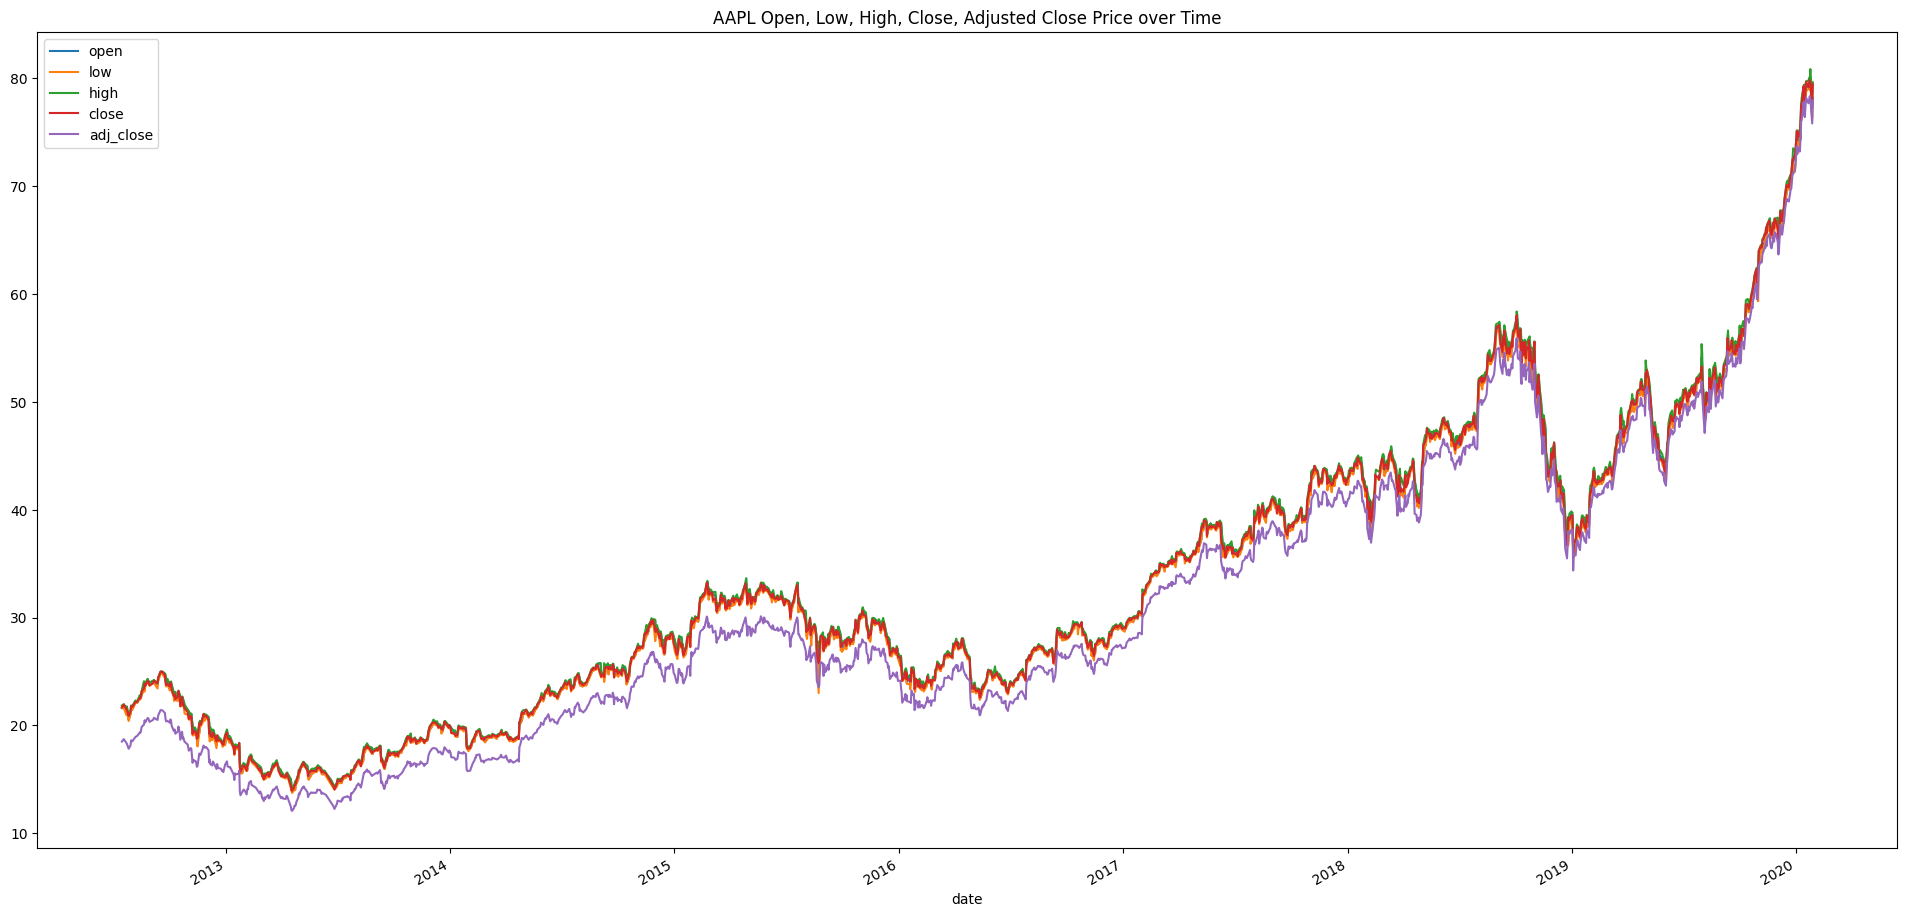

In [27]:
_ = df_aapl_us_equities_news.plot(
    x="date",
    y=["open","low","high","close", "adj_close"],
    kind="line",
    title="AAPL Open, Low, High, Close, Adjusted Close Price over Time",
    figsize=(24, 12),
)

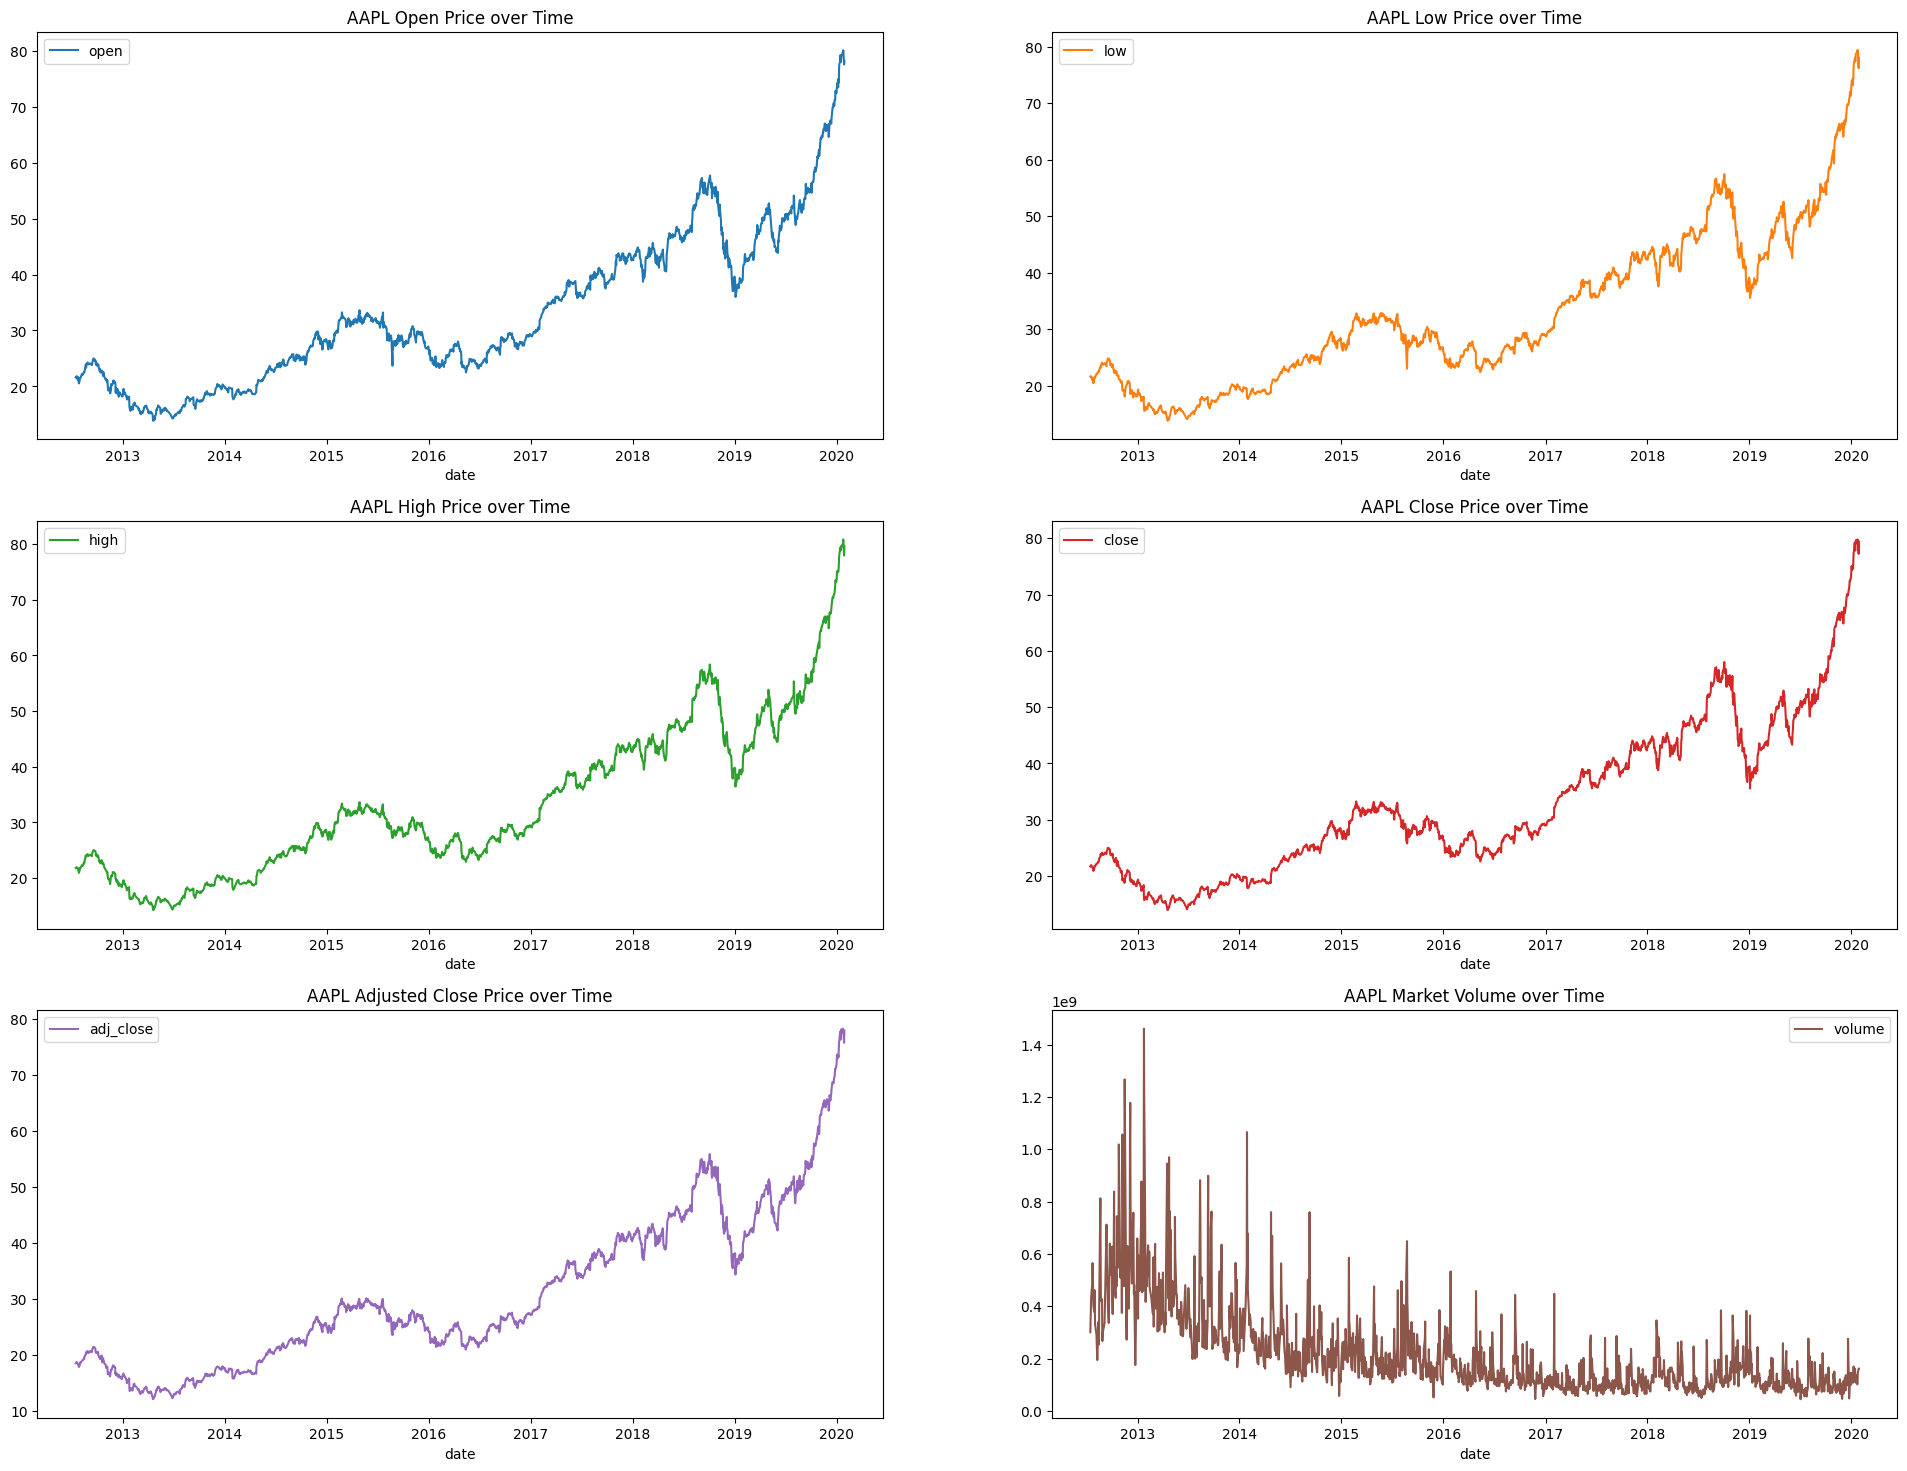

In [28]:
_ = df_aapl_us_equities_news.plot(
    x="date",
    y=["open","low","high","close", "adj_close", "volume"],
    kind="line",
    title=[
        "AAPL Open Price over Time",
        "AAPL Low Price over Time",
        "AAPL High Price over Time",
        "AAPL Close Price over Time",
        "AAPL Adjusted Close Price over Time",
        "AAPL Market Volume over Time",
    ],
    figsize=(24, 18),
    layout=(3, 2),
    subplots=True,
    sharex=False,
)

### 1.4.2 Plot category distribution

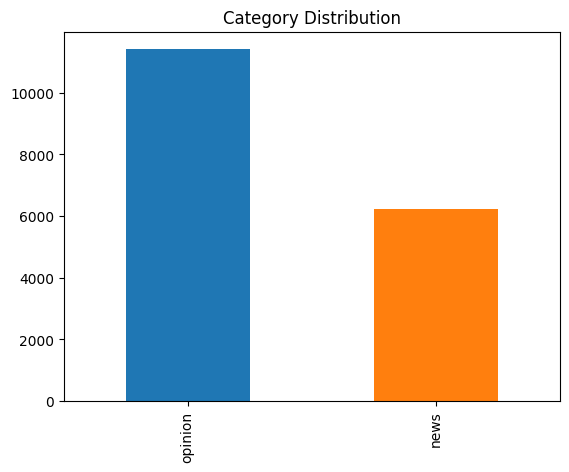

In [29]:
_ = df_aapl_us_equities_news["category"].value_counts().plot(
    kind="bar",
    color=["tab:blue", "tab:orange"],
    title="Category Distribution"
)

### 1.4.3 Plot provider distribution

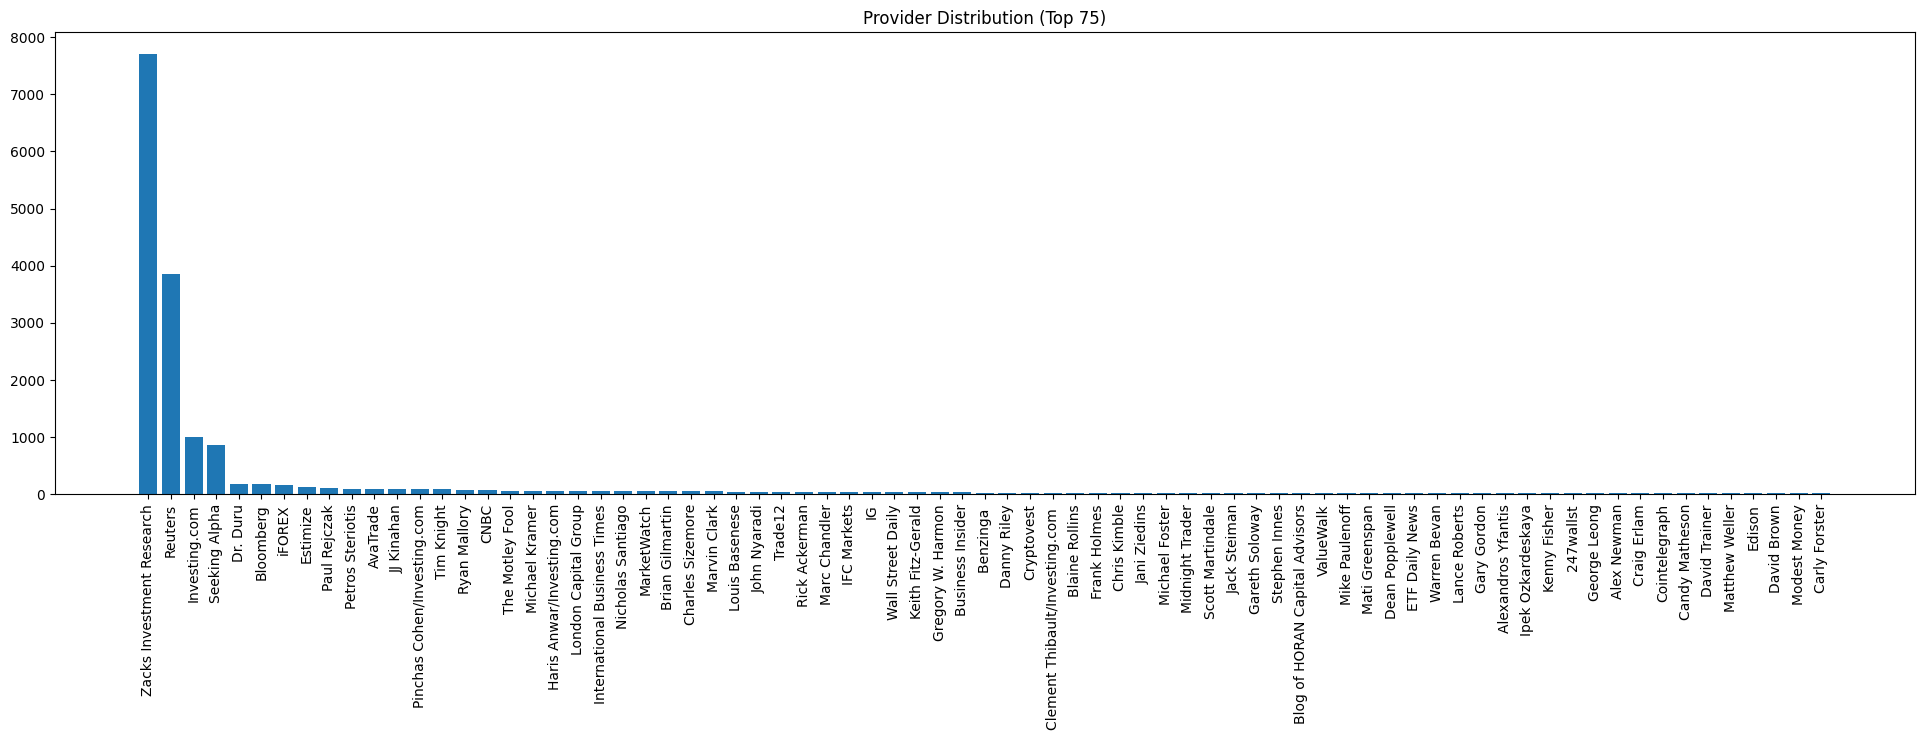

In [30]:
provider_counter = Counter(df_aapl_us_equities_news["provider"].value_counts().to_dict())

x, y = zip(*provider_counter.most_common(75))

plt.figure(figsize=(24, 6))
plt.bar(x, y)
plt.title("Provider Distribution (Top 75)")
plt.xticks(rotation=90)
plt.show()

### 1.4.4 Plot word distribution

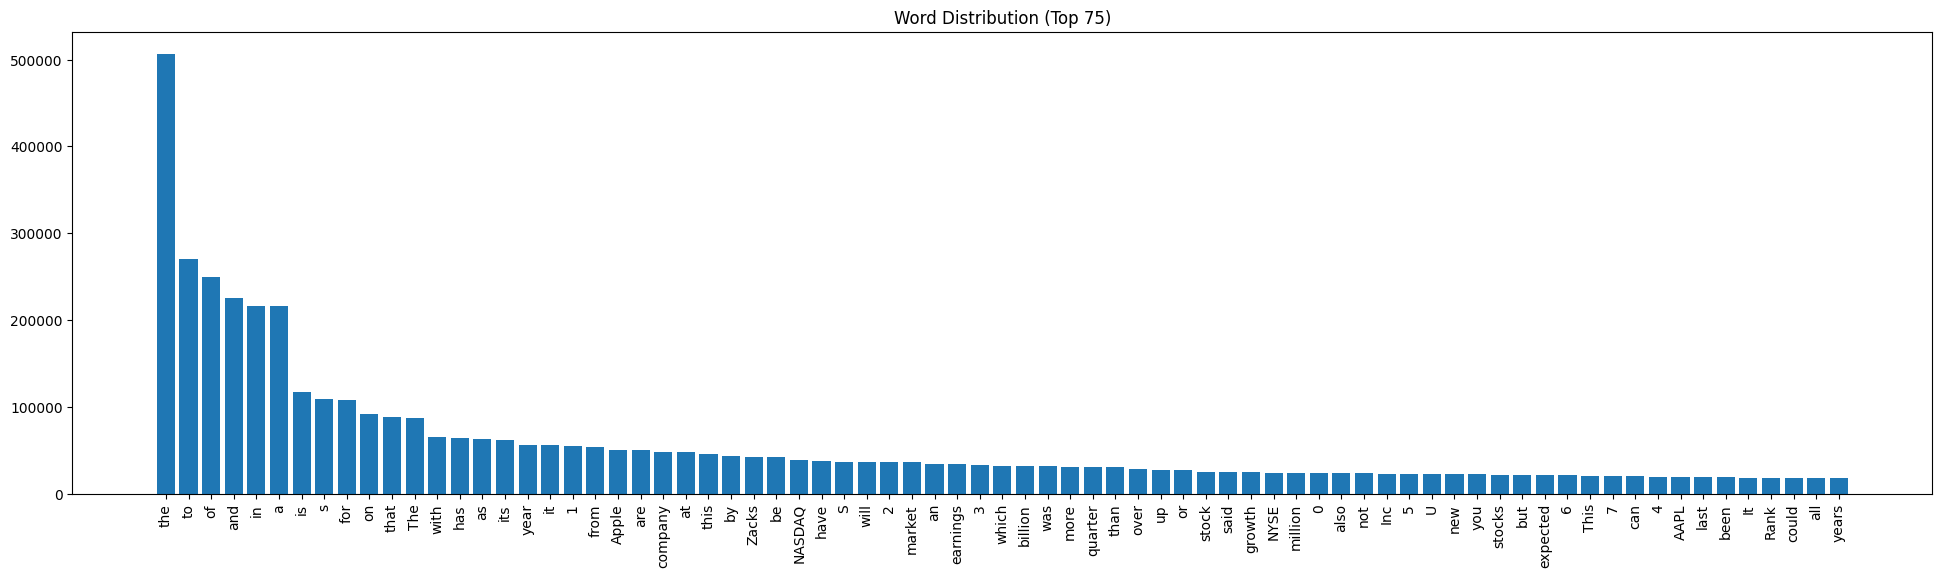

In [31]:
word_counter = Counter([word for word_list in df_aapl_us_equities_news["content"].apply(word_tokenize) for word in word_list])

x, y = zip(*word_counter.most_common(75))

plt.figure(figsize=(24, 6))
plt.bar(x, y)
plt.title("Word Distribution (Top 75)")
plt.xticks(rotation=90)
plt.show()

### 1.4.5 Plot news frequency

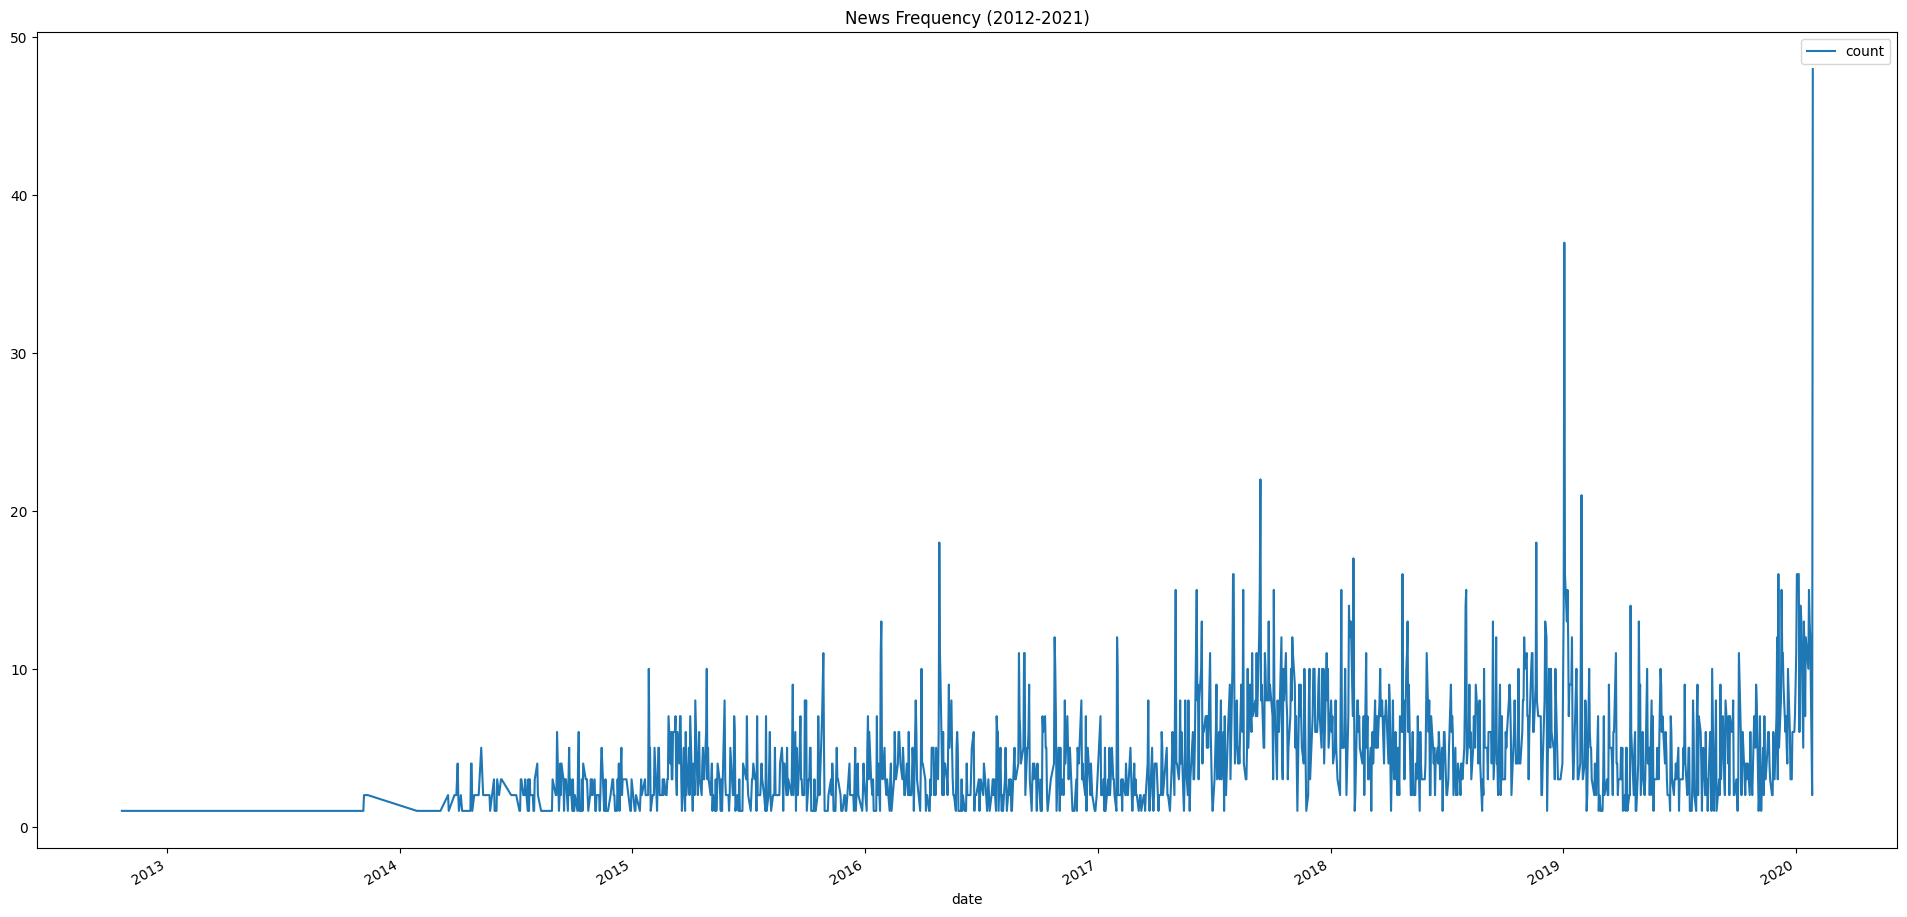

In [32]:
news_frequency = df_aapl_us_equities_news[df_aapl_us_equities_news["category"] == "news"].groupby("date").agg({"id": "count"}).rename(columns={"id": "count"})

_ = news_frequency.plot(
    kind="line",
    title="News Frequency (2012-2021)",
    figsize=(24, 12),
)

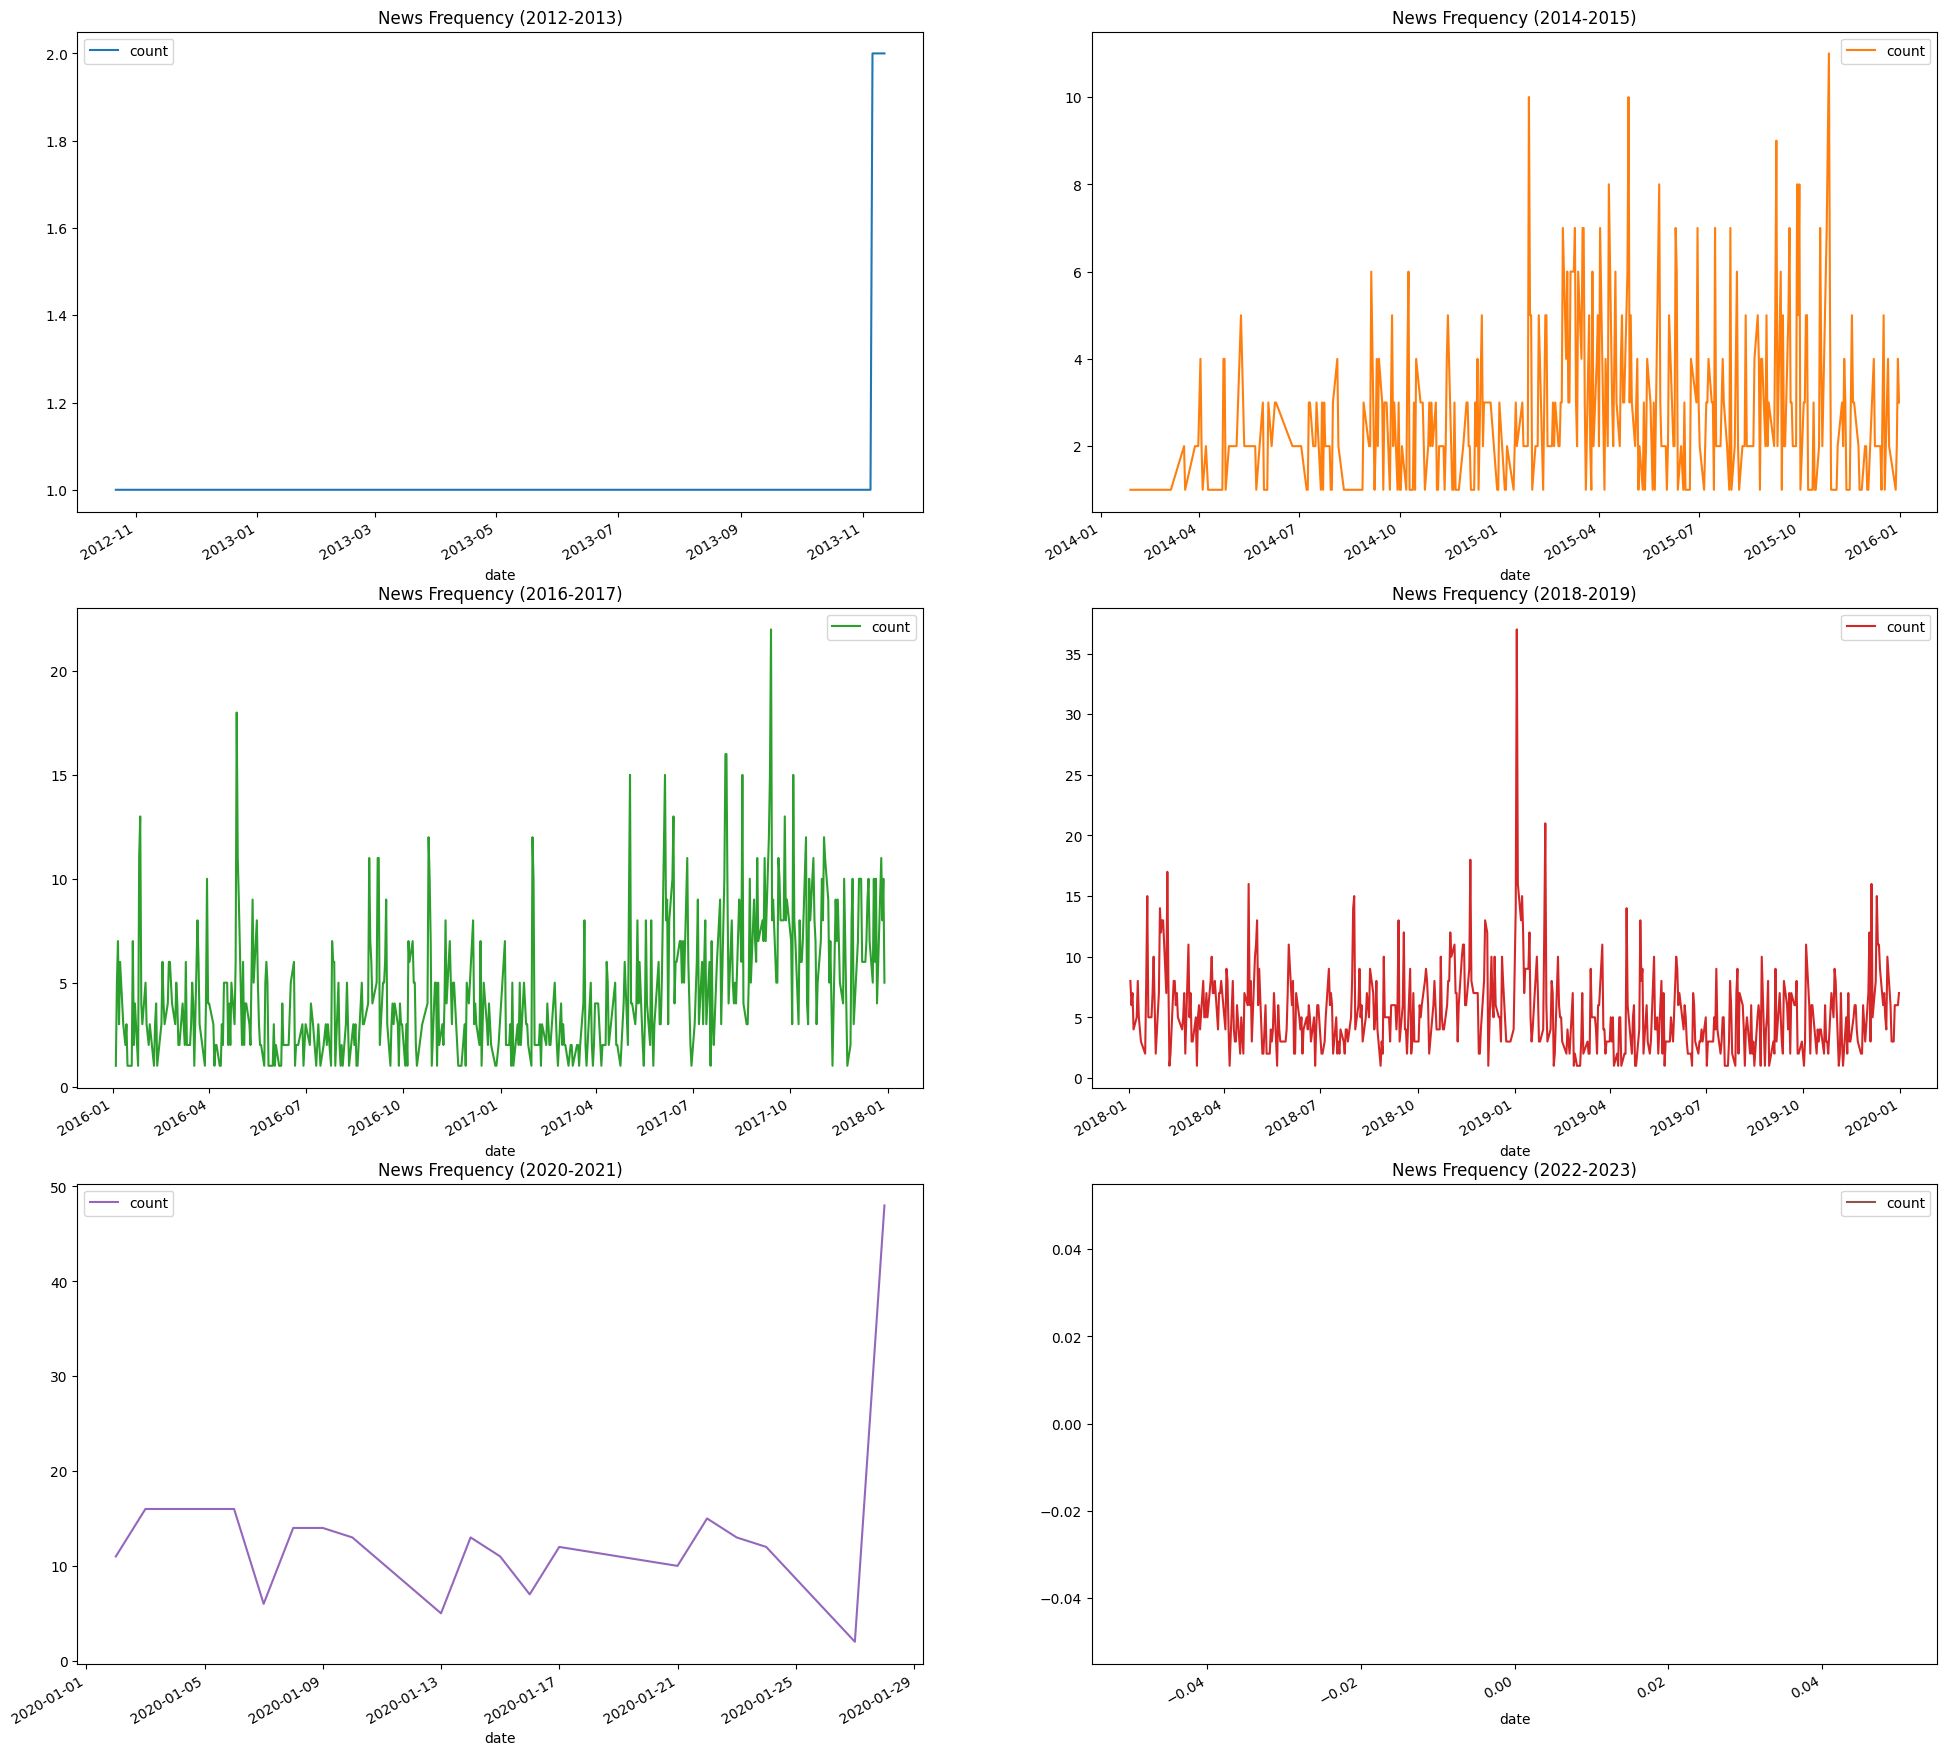

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 24))

_ = news_frequency[(news_frequency.index >= "2012-01-01") & (news_frequency.index <= "2013-12-31")].plot(
    kind="line",
    ax=axes[0, 0],
    color="tab:blue",
    title="News Frequency (2012-2013)",
)

_ = news_frequency[(news_frequency.index >= "2014-01-01") & (news_frequency.index <= "2015-12-31")].plot(
    kind="line",
    ax=axes[0, 1],
    color="tab:orange",
    title="News Frequency (2014-2015)",
)

_ = news_frequency[(news_frequency.index >= "2016-01-01") & (news_frequency.index <= "2017-12-31")].plot(
    kind="line",
    ax=axes[1, 0],
    color="tab:green",
    title="News Frequency (2016-2017)",
)

_ = news_frequency[(news_frequency.index >= "2018-01-01") & (news_frequency.index <= "2019-12-31")].plot(
    kind="line",
    ax=axes[1, 1],
    color="tab:red",
    title="News Frequency (2018-2019)",
)

_ = news_frequency[(news_frequency.index >= "2020-01-01") & (news_frequency.index <= "2021-12-31")].plot(
    kind="line",
    ax=axes[2, 0],
    color="tab:purple",
    title="News Frequency (2020-2021)",
)

_ = news_frequency[(news_frequency.index >= "2022-01-01") & (news_frequency.index <= "2023-12-31")].plot(
    kind="line",
    ax=axes[2, 1],
    color="tab:brown",
    title="News Frequency (2022-2023)",
)

### 1.4.6 Plot opinion frequency

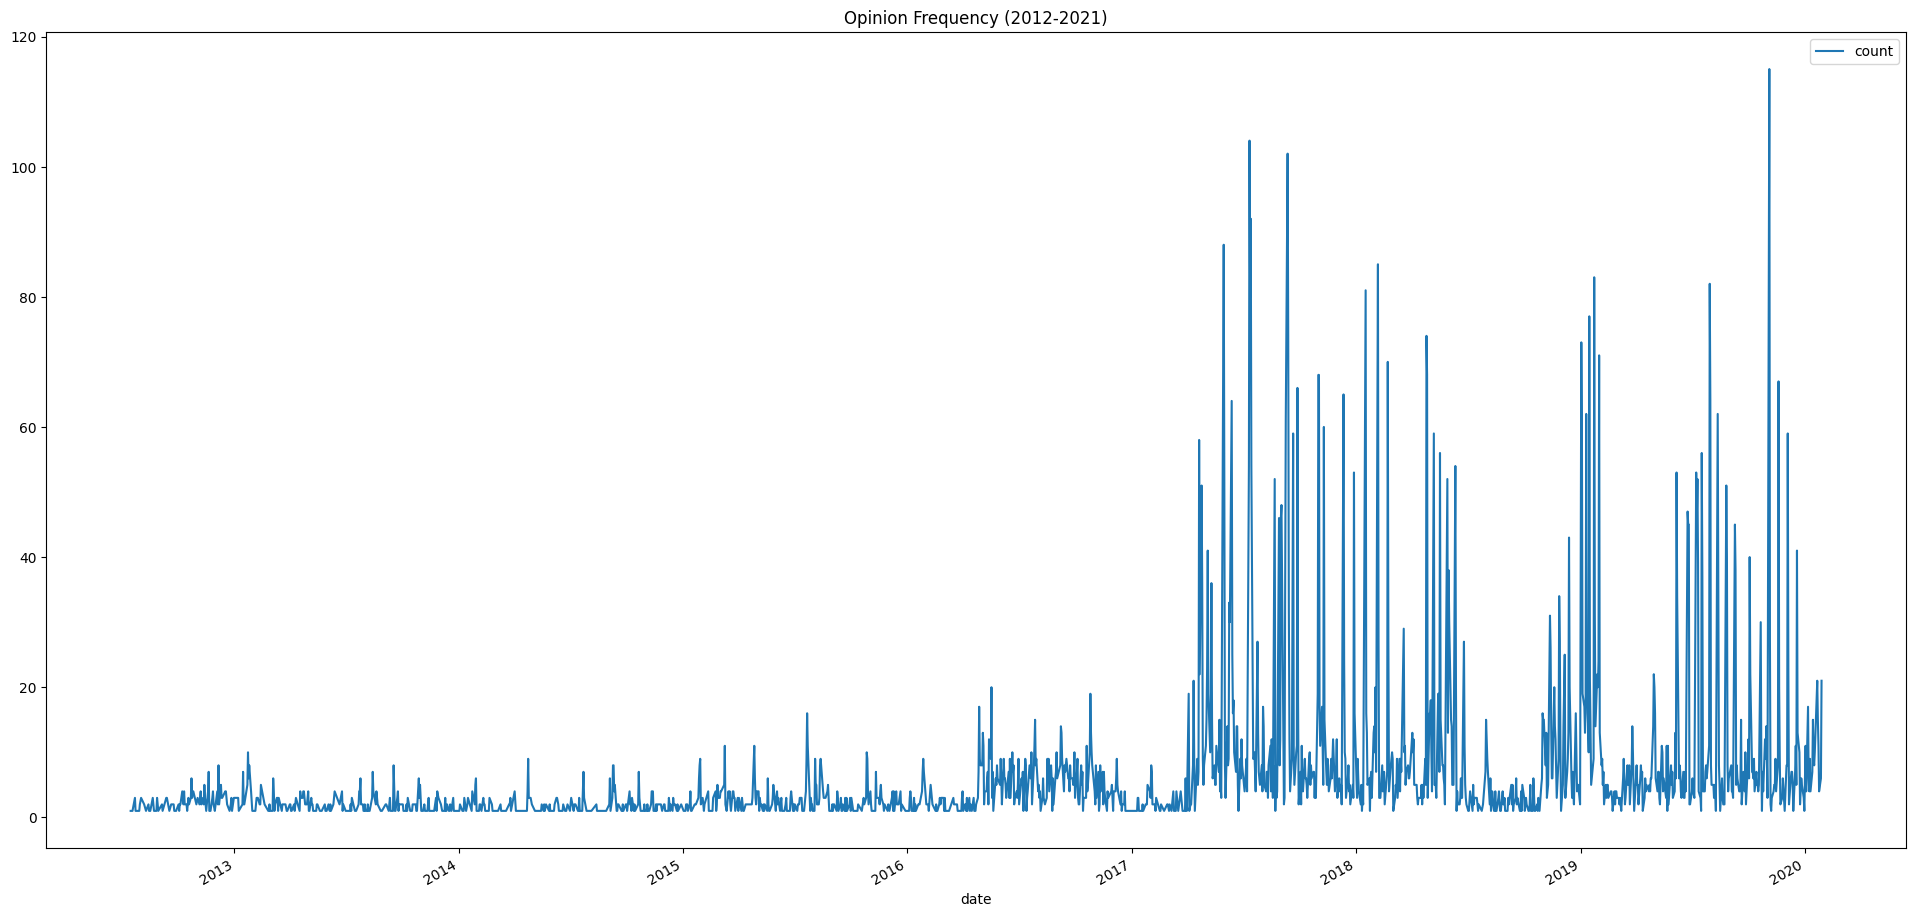

In [34]:
opinion_frequency = df_aapl_us_equities_news[df_aapl_us_equities_news["category"] == "opinion"].groupby("date").agg({"id": "count"}).rename(columns={"id": "count"})

_ = opinion_frequency.plot(
    kind="line",
    title="Opinion Frequency (2012-2021)",
    figsize=(24, 12),
)

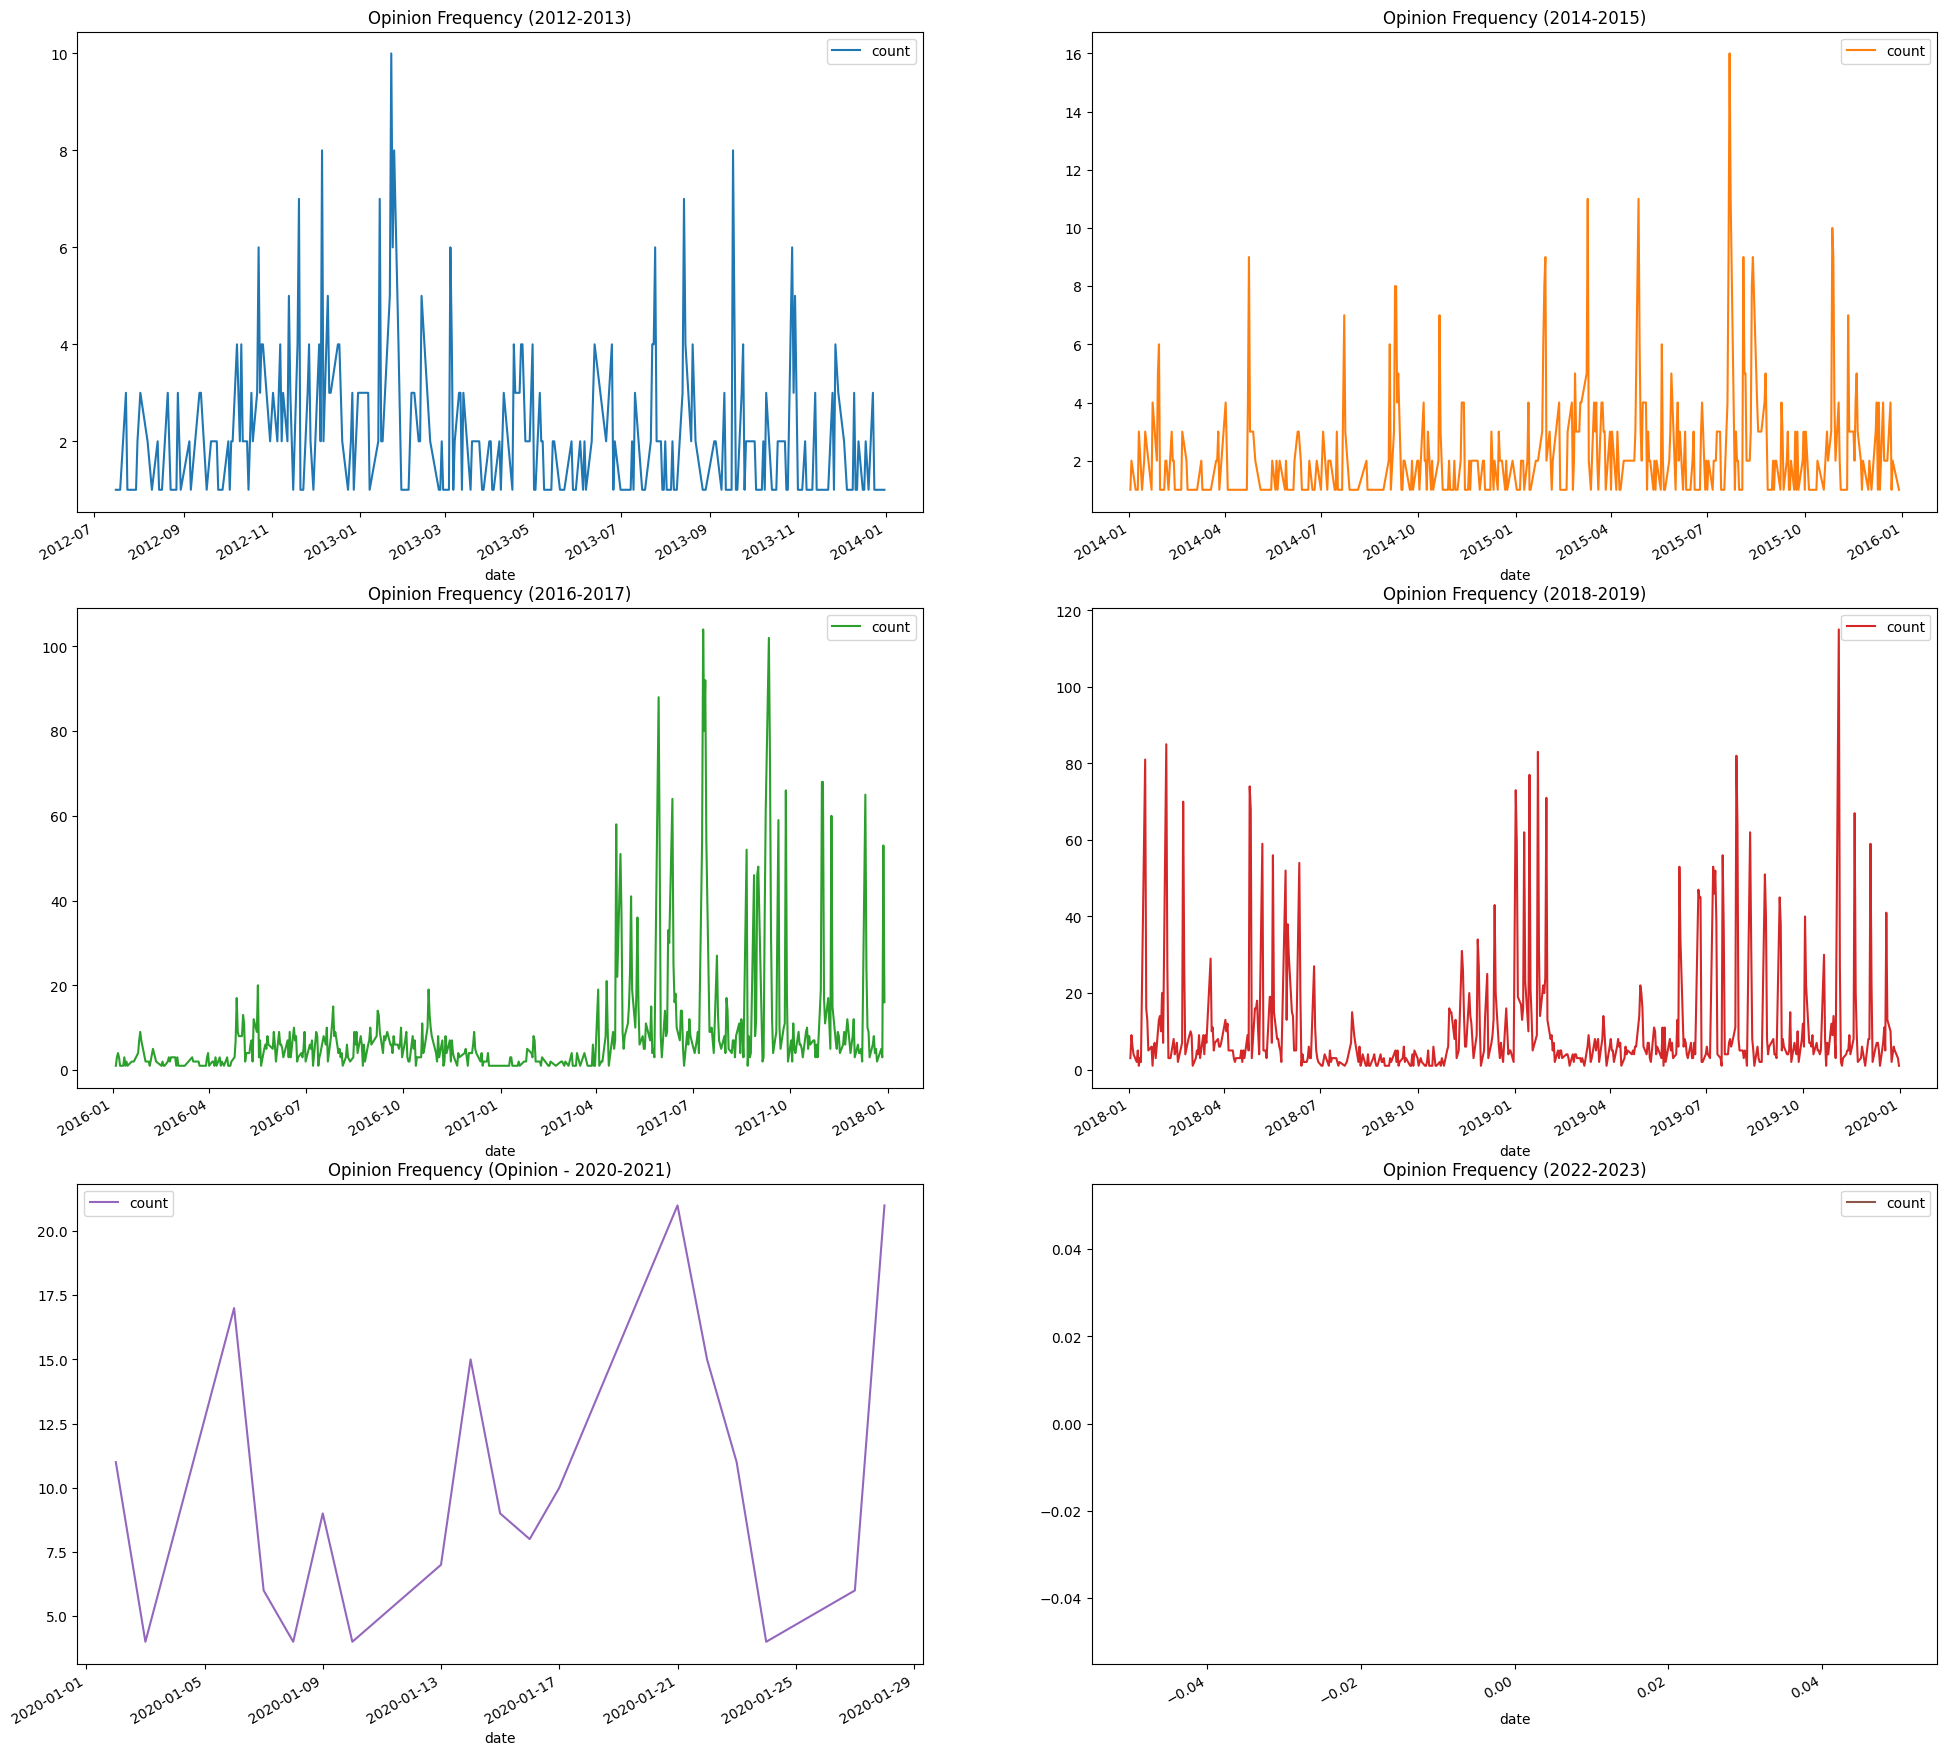

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 24))

_ = opinion_frequency[(opinion_frequency.index >= "2012-01-01") & (opinion_frequency.index <= "2013-12-31")].plot(
    kind="line",
    ax=axes[0, 0],
    color="tab:blue",
    title="Opinion Frequency (2012-2013)",
)

_ = opinion_frequency[(opinion_frequency.index >= "2014-01-01") & (opinion_frequency.index <= "2015-12-31")].plot(
    kind="line",
    ax=axes[0, 1],
    color="tab:orange",
    title="Opinion Frequency (2014-2015)",
)

_ = opinion_frequency[(opinion_frequency.index >= "2016-01-01") & (opinion_frequency.index <= "2017-12-31")].plot(
    kind="line",
    ax=axes[1, 0],
    color="tab:green",
    title="Opinion Frequency (2016-2017)",
)

_ = opinion_frequency[(opinion_frequency.index >= "2018-01-01") & (opinion_frequency.index <= "2019-12-31")].plot(
    kind="line",
    ax=axes[1, 1],
    color="tab:red",
    title="Opinion Frequency (2018-2019)",
)

_ = opinion_frequency[(opinion_frequency.index >= "2020-01-01") & (opinion_frequency.index <= "2021-12-31")].plot(
    kind="line",
    ax=axes[2, 0],
    color="tab:purple",
    title="Opinion Frequency (Opinion - 2020-2021)",
)

_ = opinion_frequency[(opinion_frequency.index >= "2022-01-01") & (opinion_frequency.index <= "2023-12-31")].plot(
    kind="line",
    ax=axes[2, 1],
    color="tab:brown",
    title="Opinion Frequency (2022-2023)",
)

### 1.4.7 Plot target distribution

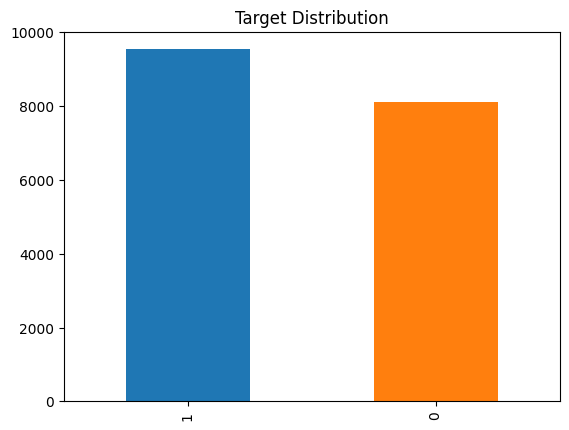

In [36]:
_ = df_aapl_us_equities_news["target"].value_counts().plot(
    kind="bar",
    color=["tab:blue", "tab:orange"],
    title="Target Distribution"
)

### 1.4.8 Plot document & word statistics

In [37]:
total_words = sum(word_counter.values())
total_unique_words = len(word_counter)
total_unique_documents = len(df_aapl_us_equities_news)
average_words_per_document = total_words / total_unique_documents

print(TEXT_START + "Total Words: " + TEXT_END + str(total_words))
print(TEXT_START + "Total Unique Words: " + TEXT_END + str(total_unique_words))
print(TEXT_START + "Total Documents: " + TEXT_END + str(total_unique_documents))
print(TEXT_START + "Total Unique Documents: " + TEXT_END + str(total_unique_documents))
print(TEXT_START + "Average Words per Document: " + TEXT_END + str(average_words_per_document))

Total Words: 11041672
Total Unique Words: 111983
Total Documents: 17634
Total Unique Documents: 17634
Average Words per Document: 626.1581036633776


## 1.5 Preprocess text

In [38]:
nlp = spacy.load("en_core_web_sm")

### 1.5.1 Consolidate text

Concats every article and title together per day

In [39]:
%%time
def concat(series):
    return reduce(lambda x, y: x + " " + y, series)


# Group by date
df_aapl_us_equities_news = df_aapl_us_equities_news.groupby("date").agg({"title": concat, "content": concat, "target": "first"})

# Concat title and content
df_aapl_us_equities_news["text"] = df_aapl_us_equities_news["title"] + " " + df_aapl_us_equities_news["content"]

# Remove index
df_aapl_us_equities_news = df_aapl_us_equities_news.reset_index()

# Select columns
df_aapl_us_equities_news = df_aapl_us_equities_news[["text", "target"]]

CPU times: user 115 ms, sys: 16.4 ms, total: 131 ms
Wall time: 130 ms


**(Optionally) Save data**

In [40]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_TEXT_CONSOL_DATASET_FILE, index=False)

### 1.5.2 Remove HTML tags

Removes HTML tags using `beautifulsoup`

In [41]:
%%time
def remove_html_tags(text):
    """
    Remove html tags from text.
    """
    soup = BeautifulSoup(text, "html.parser")

    stripped_text = soup.get_text(separator=" ")

    return stripped_text


df_aapl_us_equities_news["text"] = df_aapl_us_equities_news.progress_apply(lambda row : remove_html_tags(row["text"]), axis = 1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1740/1740 [00:00<00:00, 4036.32it/s]

CPU times: user 436 ms, sys: 468 µs, total: 437 ms
Wall time: 435 ms


**(Optionally) Save data**

In [42]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_TEXT_CONSOL_HTML_DATASET_FILE, index=False)

### 1.5.3 Remove EOL characters

Removes characters like: `\n`, `\t`, `\r`

In [43]:
%%time
def remove_eol_characters(text):
    """
    Remove EOL characters from text.
    """
    return re.sub(r"(\n|\t|\r)", "", text)


df_aapl_us_equities_news["text"] = df_aapl_us_equities_news.progress_apply(lambda row: remove_eol_characters(row["text"]), axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1740/1740 [00:00<00:00, 4763.94it/s]

CPU times: user 367 ms, sys: 0 ns, total: 367 ms
Wall time: 368 ms


**(Optionally) Save data**

In [44]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_TEXT_CONSOL_HTML_EOL_DATASET_FILE, index=False)

### 1.5.4 Remove other characters

Removes all characters except: `a-z`, `A-Z`, `À-ȕ`

In [45]:
%%time
def remove_other_characters(text):
    """
    Remove other characters from text.
    """
    return re.sub(r"[^a-zA-ZÀ-ȕ]", " ", text)


df_aapl_us_equities_news["text"] = df_aapl_us_equities_news.progress_apply(lambda row: remove_other_characters(row["text"]), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1740/1740 [00:02<00:00, 665.54it/s]

CPU times: user 2.61 s, sys: 7.52 ms, total: 2.62 s
Wall time: 2.62 s


**(Optionally) Save data**

In [46]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_TEXT_CONSOL_HTML_EOL_OTHER_DATASET_FILE, index=False)

### 1.5.5 Remove excessive spaces

Removes excessive spaces in some documents

In [47]:
%%time
def remove_excessive_spaces(text):
    """
    Remove excessive spaces from text.
    """
    return re.sub(r"\s{2,}", " ", text)


df_aapl_us_equities_news["text"] = df_aapl_us_equities_news.progress_apply(lambda row: remove_excessive_spaces(row["text"]), axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1740/1740 [00:01<00:00, 1280.40it/s]

CPU times: user 1.36 s, sys: 3.78 ms, total: 1.37 s
Wall time: 1.36 s


**(Optionally) Save data**

In [48]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_TEXT_CONSOL_HTML_EOL_OTHER_SPACE_DATASET_FILE, index=False)

### 1.5.6 Convert to lowercase

Converts all characters to lowercase

In [49]:
%%time
def convert_to_lowercase(text):
    """
    Convert to lowercase.
    """
    return text.lower()


df_aapl_us_equities_news["text"] = df_aapl_us_equities_news.progress_apply(lambda row: convert_to_lowercase(row["text"]), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1740/1740 [00:00<00:00, 34640.96it/s]

CPU times: user 56.5 ms, sys: 503 µs, total: 57 ms
Wall time: 54.8 ms


**(Optionally) Save data**

In [50]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_TEXT_CONSOL_HTML_EOL_OTHER_SPACE_LOWER_DATASET_FILE, index=False)

### 1.5.7 Remove non-dictionary words, single-character words, stopwords and lemmatize

Removes words that do not occur in the english dictionary, words that consist of one character, words that are a stopword and lemmatizes the remaining words

In [51]:
%%time
dictionary = set(words.words())


def remove_non_dictionary_single_character_stopwords_lemmatize(text):
    """
    Remove non-dictionary words, single character words, stopwords and lemmatize
    text.
    """
    return " ".join(token.lemma_ for token in nlp(text) if len(token.text) > 1 and not token.is_stop and token.text in dictionary)


df_aapl_us_equities_news["text"] = df_aapl_us_equities_news.progress_apply(lambda row: remove_non_dictionary_single_character_stopwords_lemmatize(row["text"]), axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1740/1740 [15:31<00:00,  1.87it/s]

CPU times: user 15min 18s, sys: 13.5 s, total: 15min 31s
Wall time: 15min 31s


**(Optionally) Save data**

In [52]:
if SAVE_INTERIM_DATASETS:
    df_aapl_us_equities_news.to_csv(INTERIM_DATASET_FOLDER + PREP_TEXT_CONSOL_HTML_EOL_OTHER_SPACE_LOWER_DICT_SINGLE_STOP_LEMMA_DATASET_FILE, index=False)

if SAVE_PROCESSED_DATASETS:
    df_aapl_us_equities_news.to_csv(PROCESSED_DATASET_FOLDER + PROC_TEXT_DATASET_FILE, index=False)

## 1.6 Modeling

### 1.6.1 Split data

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    df_aapl_us_equities_news["text"],
    df_aapl_us_equities_news["target"],
    stratify=df_aapl_us_equities_news["target"],
    random_state=RANDOM_SEED,
)

### 1.6.2 Run pipeline

In [54]:
VECTORIZERS = [
    ("count_vec", CountVectorizer()),
    ("tfidf_vec", TfidfVectorizer()),
]

CLASSIFIERS = [
    ("ada_clf", AdaBoostClassifier(random_state=RANDOM_SEED)),
    ("knn_clf", KNeighborsClassifier()),
    ("lr_clf", LogisticRegression(random_state=RANDOM_SEED)),
    ("nb_clf", MultinomialNB()),
    ("rf_clf", RandomForestClassifier(random_state=RANDOM_SEED)),
    ("sgd_clf", SGDClassifier(random_state=RANDOM_SEED)),
    ("svc_clf", SVC(random_state=RANDOM_SEED)),
]

PARAMETERS = {
    # Count
    "count_vec__min_df": [1, 0.05, 0.10, 0.15, 0.20], # Default: 1
    "count_vec__max_df": [1.0, 0.85, 0.65, 0.50],     # Default: 1.0

    # TFIDF
    "tfidf_vec__min_df": [1, 0.05, 0.10, 0.15, 0.20], # Default: 1
    "tfidf_vec__max_df": [1.0, 0.85, 0.65, 0.50],     # Default: 1.0
    "tfidf_vec__norm": ["l2", "l1", None],            # Default: l2
    "tfidf_vec__use_idf": [True, False],              # Default: True
    "tfidf_vec__smooth_idf": [True, False],           # Default: True
    "tfidf_vec__sublinear_tf": [False, True],         # Default: False
}

In [ ]:
%%time
timestamp = datetime.now().strftime("%-Y%m%d%H%M%S")
results = {}
models = {}

for vec_id, vec in VECTORIZERS:
    clf_pb = tqdm(CLASSIFIERS)

    for clf_id, clf in clf_pb:
        # Create pipeline
        pipeline = Pipeline([(vec_id, vec), (clf_id, clf)])

        # Select parameters
        parameters = {k: v for k, v in PARAMETERS.items() if vec_id in k or clf_id in k}
        n_params = reduce(lambda x, y: x * len(y), parameters.values(), 1)
        n_splits = 5

        # Setup search
        grid_search = GridSearchCV(
            pipeline,
            parameters,
            scoring="f1_weighted",
            return_train_score=True,
            cv=n_splits,
            n_jobs=-1,
            verbose=0,
        )

        # Log info
        clf_pb.set_description(
            f"({vec_id}, {clf_id}): np={n_params}, ns={n_splits}, tf={n_params * n_splits}",
        )
        clf_pb.refresh()

        # Train model
        grid_search.fit(X_train, y_train)

        # Evaluate model
        clf = grid_search.best_estimator_
        clf = clf.fit(X_train, y_train)

        y_test_pred = clf.predict(X_test)

        test_score = f1_score(y_test, y_test_pred, average="weighted")

        # Create results
        idx = np.argmax(grid_search.cv_results_["mean_test_score"])

        result = {
            "mean_train_score": grid_search.cv_results_["mean_train_score"][idx],
            "std_train_score": grid_search.cv_results_["std_train_score"][idx],
            "mean_val_score": grid_search.cv_results_["mean_test_score"][idx],
            "std_val_score": grid_search.cv_results_["std_test_score"][idx],
            "test_score": test_score,
            "params": grid_search.best_params_,
        }

        # Store result
        results[vec_id, clf_id] = result
        models[vec_id, clf_id] = clf

        if SAVE_MODEL_CHECKPOINTS:
            with open(MODEL_CHECKPOINTS_FOLDER + f"{timestamp}_{vec_id}_{clf_id}.pkl", "wb") as handle:
                pickle.dump((results, models), handle)

### 1.6.3 Evaluate pipeline

In [55]:
for (vec_id, clf_id), values in results.items():
    y_test_pred = models[vec_id, clf_id].predict(X_test)

    print("-" * 100 + "\n")
    print(f"Vectorizer: {vec_id}")
    print(f"Classifier: {clf_id}" + "\n")
    print(f"Best Params:")
    pprint(values["params"])
    print("")
    print("Report:")
    print(classification_report(y_test, y_test_pred, target_names = ["Positive", "Negative"]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\n" + "-" * 100)

----------------------------------------------------------------------------------------------------

Vectorizer: count_vec
Classifier: ada_clf

Best Params:
{'count_vec__max_df': 0.85, 'count_vec__min_df': 0.1}

Report:
              precision    recall  f1-score   support

    Positive       0.46      0.54      0.50       207
    Negative       0.51      0.44      0.47       228

    accuracy                           0.49       435
   macro avg       0.49      0.49      0.48       435
weighted avg       0.49      0.49      0.48       435

Confusion Matrix:
[[111  96]
 [128 100]]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Vectorizer: count_vec
Classifier: knn_clf

Best Params:
{'count_vec__max_df': 0.5, 'count_vec__min_df': 0.05}

Report:
              precision    recall  f1-score   support

    Positive       0.51      0.46

### 1.6.4 Best model

In [56]:
best_score = -1.00
best_vec_id = None
best_clf_id = None
best_values = None
best_model = None

for (vec_id, clf_id), values in results.items():
    score = values["test_score"]
    if score > best_score:
        best_score = score
        best_vec_id = vec_id
        best_clf_id = clf_id
        best_values = values
        best_model = models[vec_id, clf_id]

y_test_pred = best_model.predict(X_test)

print("-" * 100 + "\n")
print(f"Best Vectorizer: {best_vec_id}")
print(f"Best Classifier: {best_clf_id}" + "\n")
print(f"Best Params:")
pprint(best_values["params"])
print("")
print("Report:")
print(classification_report(y_test, y_test_pred, target_names = ["Positive", "Negative"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\n" + "-" * 100)

----------------------------------------------------------------------------------------------------

Best Vectorizer: count_vec
Best Classifier: knn_clf

Best Params:
{'count_vec__max_df': 0.5, 'count_vec__min_df': 0.05}

Report:
              precision    recall  f1-score   support

    Positive       0.51      0.46      0.49       207
    Negative       0.55      0.60      0.57       228

    accuracy                           0.53       435
   macro avg       0.53      0.53      0.53       435
weighted avg       0.53      0.53      0.53       435

Confusion Matrix:
[[ 96 111]
 [ 92 136]]

----------------------------------------------------------------------------------------------------


### 1.6.5 Tune best model

In [57]:
PARAMETERS = {
    "knn_clf__n_neighbors": [2, 3, 4, 5, 6],
    "knn_clf__weights": ["uniform", "distance"],
    "knn_clf__leaf_size": [10, 20, 30, 40, 50, 60],
    "knn_clf__metric": ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"],
}

In [58]:
%%time
# Setup search
grid_search = GridSearchCV(
    best_model,
    PARAMETERS,
    scoring="f1_weighted",
    return_train_score=True,
    cv=5,
    n_jobs=-1,
    verbose=1,
)

# Train model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
CPU times: user 24.1 s, sys: 12.8 s, total: 36.8 s
Wall time: 24min 8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('count_vec',
                                        CountVectorizer(max_df=0.5,
                                                        min_df=0.05)),
                                       ('knn_clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn_clf__leaf_size': [10, 20, 30, 40, 50, 60],
                         'knn_clf__metric': ['cityblock', 'cosine', 'euclidean',
                                             'l1', 'l2', 'manhattan'],
                         'knn_clf__n_neighbors': [2, 3, 4, 5, 6],
                         'knn_clf__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1_weighted', verbose=1)

### 1.6.6 Evaluate best model

In [59]:
y_test_pred = grid_search.best_estimator_.predict(X_test)

print("-" * 100 + "\n")
print(f"Best Vectorizer: {best_vec_id}")
print(f"Best Classifier: {best_clf_id}" + "\n")
print(f"Best Params:")
pprint(grid_search.best_params_)
print("")
print("Report:")
print(classification_report(y_test, y_test_pred, target_names = ["Positive", "Negative"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\n" + "-" * 100)

----------------------------------------------------------------------------------------------------

Best Vectorizer: count_vec
Best Classifier: knn_clf

Best Params:
{'knn_clf__leaf_size': 10,
 'knn_clf__metric': 'euclidean',
 'knn_clf__n_neighbors': 5,
 'knn_clf__weights': 'uniform'}

Report:
              precision    recall  f1-score   support

    Positive       0.51      0.46      0.49       207
    Negative       0.55      0.60      0.57       228

    accuracy                           0.53       435
   macro avg       0.53      0.53      0.53       435
weighted avg       0.53      0.53      0.53       435

Confusion Matrix:
[[ 96 111]
 [ 92 136]]

----------------------------------------------------------------------------------------------------
